Start with each college, compared to national, for all years: t-test for proportions\
Each college, compared to its local, for all years: t-test for all proportions


In [83]:
%pip install scipy
%pip install statsmodels

from scipy.stats import ttest_rel, ttest_ind, spearmanr
from statsmodels.stats.multitest import multipletests
import pandas as pd


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [84]:
jobs = pd.read_csv('jobs.csv')
colleges = pd.read_csv('colleges.csv')

colleges.rename(columns={'Category': 'Major Field'}, inplace=True)

total_employment_dict = jobs[jobs['Occupation Title'] == 'All Occupations'].set_index(['Year', 'Area'])['Total Employment'].to_dict()
total_employment_dict = jobs[jobs['Occupation Title'] == 'All Occupations'].groupby('Year')['Total Employment'].sum().to_dict()

def calculate_proportion(row):
    key = (row['Year'])
    if key in total_employment_dict:
        # print(f"Key: {key}, Total Employment: {total_employment_dict[key]}, Row Employment: {row['Total Employment']}, proportion: {row['Total Employment'] / total_employment_dict[key]}")
        return row['Total Employment'] / total_employment_dict[key]
    else:
        print(f"Key not found: {key}")
        return None

def sum_employment_by_major(job_df):
    employment_df = pd.DataFrame(columns=['Major Field', 'Total Employment', 'Proportions'])
    for index, row in job_df.iterrows():
        major = row['Major Field']
        employment = row['Total Employment']
        proportion = row['Proportions']
        
        if major in employment_df['Major Field'].values:
            employment_df.loc[employment_df['Major Field'] == major, 'Total Employment'] += employment
            employment_df.loc[employment_df['Major Field'] == major, 'Proportions'] += proportion
        else:
            employment_df.loc[len(employment_df)] = {'Major Field': major, 'Total Employment': employment, 'Proportions': proportion}
    return employment_df

def compare_job_to_college(jobs, colleges, college, college_year, job_year, area):
    if area == 'all':
        jobs = jobs[jobs['Occupation Group'] != ""]
        jobs['Proportions'] = jobs.apply(calculate_proportion, axis=1)
        job_df = jobs[jobs['Year'] == job_year]
    else:
        jobs = jobs[jobs['Occupation Group'] == 'major']
        job_df = jobs[(jobs['Year'] == job_year) & (jobs['Area'] == area)]
    college_df = colleges[(colleges['Year'] == college_year) & (colleges['College'] == college)]
    job_employment_df = sum_employment_by_major(job_df)
    job_employment_df['Proportions'] *= 100
    combined_df = pd.merge(job_employment_df, college_df, on='Major Field')
    _, p = ttest_rel(combined_df['Proportions'], combined_df['Bachelors'])
    return p
    
college_to_area_map = {
    'ucsd': "San Diego-Carlsbad, CA",
    'asu': "Winston-Salem, NC",
    'colgate': "Utica-Rome, NY",
    'dartmouth': "West Central-Southwest New Hampshire nonmetropolitan area",
    'caltech': "Los Angeles-Long Beach-Anaheim, CA",
    'george': "Washington-Arlington-Alexandria, DC-VA-MD-WV Metropolitan Division",
    'umich': "Ann Arbor, MI",
    'wsu': "Spokane-Spokane Valley, WA"
}

p_value_df = pd.DataFrame(columns=['College', 'College Year', 'Job Year', 'Area', 'P-Value'])
for key in college_to_area_map.keys():
    for year in range(2014, 2023):
        for area in ['all', college_to_area_map[key]]:
            for i in range(-6, 1):
                if year + i in range(2014, 2023):
                    college_year = year
                    job_year = year + i
                    p_value = compare_job_to_college(jobs, colleges, key, college_year, job_year, area)
                    p_value_df.loc[len(p_value_df)] = {'College': key, 'College Year': college_year, 'Job Year': job_year, 'Area': area, 'P-Value': p_value}

print(p_value_df)
    

    College  College Year  Job Year                        Area   P-Value
0      ucsd          2014      2014                         all  0.671389
1      ucsd          2014      2014      San Diego-Carlsbad, CA  0.046753
2      ucsd          2015      2014                         all  0.676486
3      ucsd          2015      2015                         all  0.674776
4      ucsd          2015      2014      San Diego-Carlsbad, CA  0.369522
..      ...           ...       ...                         ...       ...
667     wsu          2022      2018  Spokane-Spokane Valley, WA  0.998609
668     wsu          2022      2019  Spokane-Spokane Valley, WA  0.985409
669     wsu          2022      2020  Spokane-Spokane Valley, WA  0.986464
670     wsu          2022      2021  Spokane-Spokane Valley, WA  0.990345
671     wsu          2022      2022  Spokane-Spokane Valley, WA  0.978730

[672 rows x 5 columns]


In [91]:
# write to csv so other people don't have to run 24 mins of code
p_value_df.to_csv('p_value.csv', index=False)

# print out significant p-values
for index, row in p_value_df.iterrows():
    if row['P-Value'] < 0.05:
        print(f"School: {row['College']}, College Year: {row['College Year']}, Job Year: {row['Job Year']}, Area: {row['Area']}, P-Value: {row['P-Value']}")

p_value_df = p_value_df.sort_values(by='P-Value')
print(p_value_df.head())

School: ucsd, College Year: 2014, Job Year: 2014, Area: San Diego-Carlsbad, CA, P-Value: 0.04675311434112928
       College  College Year  Job Year                    Area   P-Value
1         ucsd          2014      2014  San Diego-Carlsbad, CA  0.046753
298  dartmouth          2020      2018                     all  0.083047
324  dartmouth          2022      2018                     all  0.085374
311  dartmouth          2021      2018                     all  0.085489
297  dartmouth          2020      2017                     all  0.089953


In [89]:
# Bonferroni Correction is most likely not needed because we can manually adjust for false positives
for college in p_value_df['College'].unique():
    p_value_list = p_value_df[p_value_df['College'] == college]
    rejected, p_adjusted, _, _ = multipletests(p_value_list['P-Value'], alpha=0.05, method='holm')
    print(f"{college}: {rejected}")
    for i in range(len(rejected)):
        if rejected[i]:
            print(f"School: {p_value_list.iloc[i]['College']}, College Year: {p_value_list.iloc[i]['College Year']}, Job Year: {p_value_list.iloc[i]['Job Year']}, Area: {p_value_list.iloc[i]['Area']}, P-Value: {p_value_list.iloc[i]['P-Value']}")
rejected, p_adjusted, _, _ = multipletests(p_value_df['P-Value'], alpha=0.05, method='holm')
print(rejected)

ucsd: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
asu: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fa


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
         Major Field  Total Employment  Proportions  Year    College  \
0   Computer science            480420    25.794228  2020  dartmouth   
1        Engineering            913930    59.808106  2020  dartmouth   
2  Physical sciences            143630    10.311279  2020  dartmouth   
3               Arts            269470    12.811595  2020  dartmouth   
4    Social sciences           1082260    73.490479  2020  dartmouth   

   Bachelors  
0        8.0  
1        9.0  
2        4.0  
3        5.0  
4       45.0  
SignificanceResult(statistic=np.float64(0.9999999999999999), pvalue=np.float64(1.4042654220543672e-24))


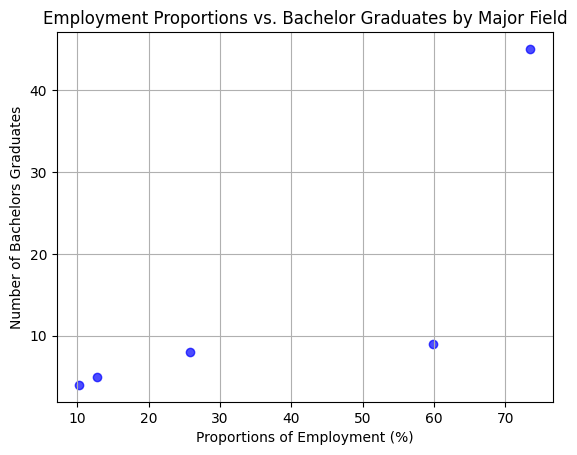

In [94]:
%pip install matplotlib
import matplotlib.pyplot as plt

dartmouth_data = colleges[(colleges['Year'] == 2020) & (colleges['College'] == 'dartmouth')]
job_2018 = jobs[(jobs['Year'] == 2018)]
job_2018 = job_2018[job_2018['Occupation Group'] == 'major']
job_2018['Proportions'] *= 100
job_2018 = sum_employment_by_major(job_2018)
combined_df = pd.merge(job_2018, dartmouth_data, on='Major Field')
print(combined_df)
print(spearmanr(combined_df['Proportions'], combined_df['Bachelors']))

plt.scatter(combined_df['Proportions'], combined_df['Bachelors'], color='blue', alpha=0.7)
plt.xlabel('Proportions of Employment (%)')
plt.ylabel('Number of Bachelors Graduates')
plt.title('Employment Proportions vs. Bachelor Graduates by Major Field')
plt.grid(True)
plt.show()